In [88]:
import torch
from transformers import *

In [81]:
import numpy as np
import pandas as pd

STORY = "pieman" # pieman, 21st_year

token_stimulus_df = pd.read_csv("data/stimuli/{}/tr_tokens.csv".format(STORY))
token_stimulus_df.n_tokens = token_stimulus_df.n_tokens.fillna(0)
token_stimulus_df.tokens = token_stimulus_df.tokens.fillna("")

In [82]:
token_stimulus_df.head()

,tr,start_ts,end_ts,tr.1,tokens,n_tokens,tr_shift,prev_tr
0,10,15.089999,16.310000,10,I began my illustrious,4.0,NaN,NaN
1,11,16.330000,17.929999,11,career in journalism,3.0,1.0,10.0
2,12,18.469999,19.390000,12,in the Bronx where,4.0,1.0,11.0
3,13,19.390000,20.890000,13,I toiled as a hard,5.0,1.0,12.0
4,14,20.890000,22.360000,14,boiled reporter for the,4.0,1.0,13.0


In [83]:
token_stimulus_df.tail()

,tr,start_ts,end_ts,tr.1,tokens,n_tokens,tr_shift,prev_tr
272,282,NaN,NaN,282,,0.0,NaN,NaN
273,283,424.929999,425.880000,283,And she said Oh good,5.0,2.0,281.0
274,284,426.840000,427.430000,284,Now buy me a,4.0,1.0,283.0
275,285,427.429999,428.939999,285,beer and tell me,4.0,1.0,284.0
276,286,428.940000,429.480000,286,all about it,3.0,1.0,285.0


In [84]:
len(token_stimulus_df)

277

### Stimulus Analysis
Quick checks: how many words do we have per TR?  
Use this to determine parameters for attention head analysis.

In [85]:
token_stimulus_df.n_tokens.describe()

count    277.000000
mean       3.454874
std        2.127022
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       12.000000
Name: n_tokens, dtype: float64

In [86]:
token_stimulus_df.n_tokens.value_counts().sort_index()

0.0     23
1.0     23
2.0     48
3.0     59
4.0     44
5.0     41
6.0     18
7.0      4
8.0     12
9.0      4
12.0     1
Name: n_tokens, dtype: int64

# RSMs from BERT

#### Set up BERT model

In [89]:
bert_weights = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights)

# Models can return full list of hidden-states & attentions weights at each layer
bert = BertModel.from_pretrained(bert_weights,
                                 output_hidden_states=True,
                                 output_attentions=True)

In [90]:
def stimulus_to_rsm_dataframe(stimulus, tr_lookback_window):

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get the whole window we're going to 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        window_tokens = torch.tensor([bert_tokenizer.encode(window_stimulus, add_special_tokens=True)])

        tr_tokens = torch.tensor([bert_tokenizer.encode(tr, add_special_tokens=False)])[0]

        with torch.no_grad():

            tr_activation_array[i] = {}
            bert_states, bert_attentions = bert(window_tokens)[-2:]
            
            num_bert_layers = len(bert_states)

            for l, layer in enumerate(bert_states):
                
                if len(tr_tokens) > 0:
                    # ASSUMPTION: we do not want to include the CLS/SEP token in the TR RSM.
                    # If we do, switch indexing here to include last token.
                    tr_activations = layer[0][-(len(tr_tokens) + 1):-1]
                    
                else:
                    # ASSUMPTION: if we don't have any tokens in this TR, use the last token's representation. --> should we use lasttoken or CLS/SEP?
                    tr_activations = layer[0][-2:-1]

                # ASSUMPTION: take the mean of all tokens falling inside the TR stimuli window.
                tr_activation_array[i][l] = torch.mean(tr_activations, 0)

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))
        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

## Activation RSMs

Generate a set of RSMs for a full text.

In [91]:
ANALYSIS_NAME = "all_activations"

In [92]:
activation_rsm_dfs = stimulus_to_rsm_dataframe(token_stimulus_df.tokens.values, 20)

In [93]:
print("Processed {} stimulus windows, returning {} RSM DFs.".format(len(token_stimulus_df), len(activation_rsm_dfs[0])))

Processed 277 stimulus windows, returning 277 RSM DFs.


In [13]:
import os 

destination_path = "data/{}/{}/{}".format(STORY, bert_weights, ANALYSIS_NAME)
try:
    os.mkdir(destination_path)
except:
    pass

for i, df in enumerate(activation_rsm_dfs):
    np_array = df.to_numpy()
    np.save("data/{}/{}/{}/layer_{}_rsm.npy".format(STORY, bert_weights, ANALYSIS_NAME, i), np_array)

In [14]:
# Copying to PNI

print("Run from {} directory:".format(bert_weights))
print('\tscp -r {} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/'.format(ANALYSIS_NAME, STORY, bert_weights))

print("\nTo check results:\n\t ssh tsumers@apps.pni.princeton.edu")

Run from bert-base-uncased directory:
	scp -r all_activations tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/pieman/bert-base-uncased/

To check results:
	 ssh tsumers@apps.pni.princeton.edu


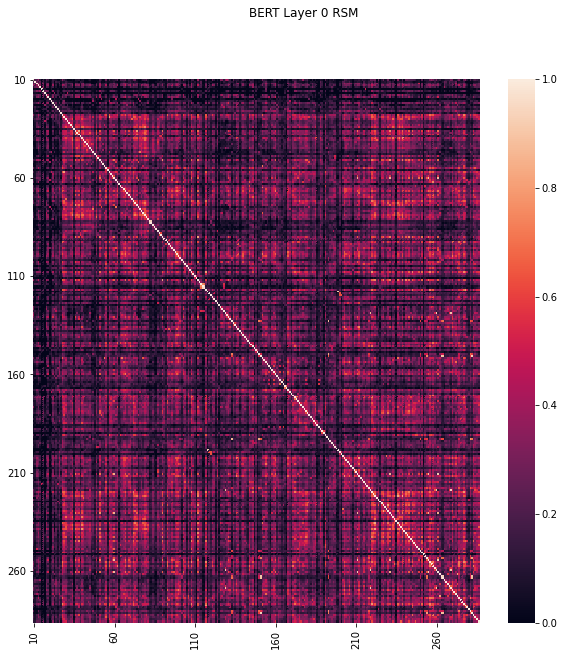

In [94]:
import matplotlib.pylab as plt
import seaborn as sns

tick_labels = "tr" # story_section (for 21st_year); tr
tick_interval = 50 # 50, 100, 200

plt.figure(figsize=(10,10))
ax = sns.heatmap(activation_rsm_dfs[0], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

ax.set_xticks(ax.get_xticks()[::tick_interval])
ax.set_yticks(ax.get_yticks()[::tick_interval])
plt.suptitle("BERT Layer 0 RSM");

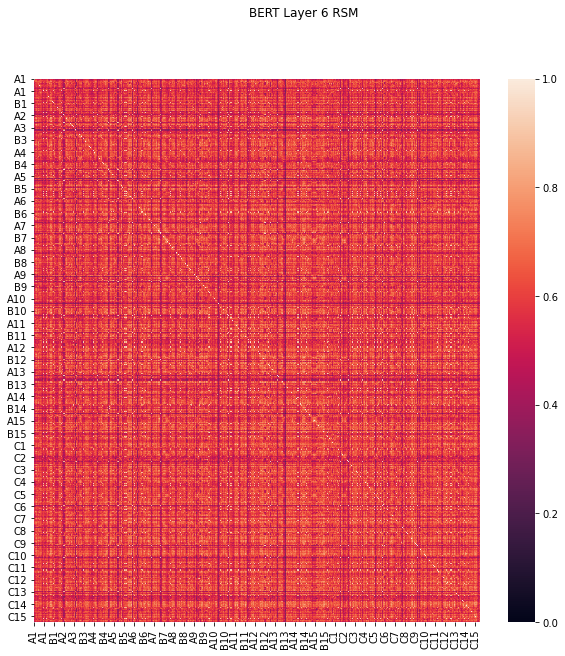

In [23]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(activation_rsm_dfs[5], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

ax.set_xticks(ax.get_xticks()[::tick_interval])
ax.set_yticks(ax.get_yticks()[::tick_interval])

plt.suptitle("BERT Layer 6 RSM");

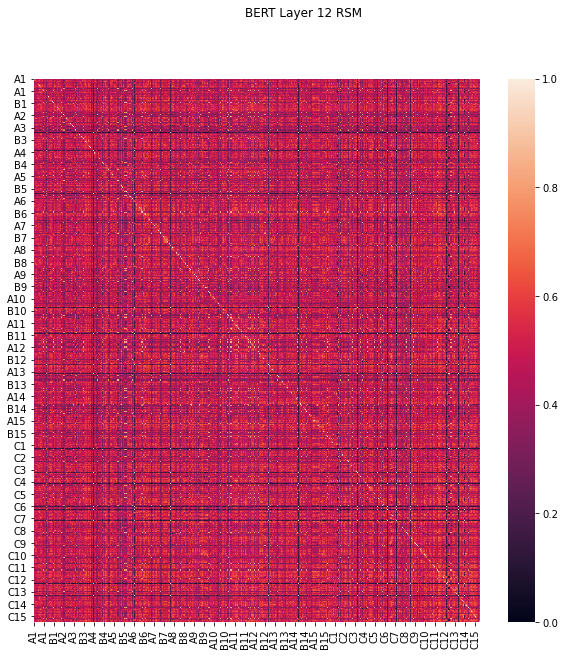

In [22]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(activation_rsm_dfs[-1], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

ax.set_xticks(ax.get_xticks()[::tick_interval])
ax.set_yticks(ax.get_yticks()[::tick_interval])

plt.suptitle("BERT Layer 12 RSM");

# Attention RSMs

In [27]:
def stimulus_to_attention_rsm_dataframe(stimulus, tr_lookback_window, num_window_tokens=10, num_tr_tokens=6, verbose=False):
    """Return window_tokens x tr_tokens x num_heads attention matrix"""

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get all of the stimulus for the TR lookback window (e.g. words for last X seconds) 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        
        # Get the list of BERT tokens involved in that window
        window_tokens = bert_tokenizer.encode_plus(window_stimulus, return_tensors='pt', add_special_tokens=True)
        
        # window_token_ids is now a tensor containing *all* of the tokens in this TR stimulus window.
        # We need to filter it down to our fixed dimensionality, window_tokens
        window_token_ids = window_tokens['input_ids']
    
        if len(window_token_ids[0]) < num_window_tokens:
            # We don't have enough words yet. This is typical for the first few TRs-- we need to build up context.
            if verbose:
                print("TR {}: not enough tokens ({}/{})".format(i, len(window_token_ids[0]), num_window_tokens))
            continue

        truncated_window_token_ids = window_token_ids[0][-num_window_tokens:]
#         if verbose:
#             print("TR {}: more than enough tokens ({}/{}), trimmed to {}.".format(i, len(window_token_ids[0]), num_window_tokens, len(truncated_window_token_ids)))
    
        with torch.no_grad():

            tr_activation_array[i] = {}
            _, bert_attentions = bert(truncated_window_token_ids.reshape(1, -1))[-2:]
            num_bert_layers = len(bert_attentions)

            # bert_attentions is now a tuple of length n_layers
            # Each element of the tuple contains the outputs of each attention head in that layer.
            # So, for example, bert_attentions[0] will be of torch.Size([1, n_heads, num_window_tokens, num_window_tokens])
            # Running this on bert-base with num_window_tokens = 40 will yield:
            # len(bert_attentions) = 12 --> 12 layers in the model
            # bert_attentions[0].shape = torch.Size([1, 12, 40, 40]) --> 12 attention heads, 40x40 attention weights
#             if verbose:
#                 print("Extracting heads from {} layers, each of shape {}.".format(num_bert_layers, bert_attentions[0].shape))
            
            for l, layer in enumerate(bert_attentions):
                                
                # Need to flatten our attentions to 1D vector.
                # This is complicated but basically collapses all attention heads down to a single vector
                # which will have length = n_heads * n_window_tokens * n_window_tokens 
                tr_activations = layer[0].reshape(1,-1)[0]

                tr_activation_array[i][l] = tr_activations

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
            
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))

        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

In [28]:
ANALYSIS_NAME = "all_attentions"

attention_rsm_dfs = stimulus_to_attention_rsm_dataframe(token_stimulus_df.tokens.values, 10, verbose=True)

TR 0: not enough tokens (7/10)


In [29]:
print("Processed {} stimulus windows, returning {} RSM DFs.".format(len(token_stimulus_df), len(attention_rsm_dfs[0])))

Processed 2225 stimulus windows, returning 2224 RSM DFs.


In [23]:
import os 

destination_path = "data/{}/{}/{}".format(STORY, bert_weights, ANALYSIS_NAME)
# os.mkdir(destination_path)

for i, df in enumerate(attention_rsm_dfs):
    np_array = df.to_numpy()
    np.save("data/{}/{}/{}/layer_{}_rsm.npy".format(STORY, bert_weights, ANALYSIS_NAME, i), np_array)

In [24]:
# Copying to PNI

print("Run from {} directory:".format(bert_weights))
print('\tscp -r {} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/'.format(ANALYSIS_NAME, STORY, bert_weights))

print("\nTo check results:\n\t ssh tsumers@apps.pni.princeton.edu")

Run from bert-base-uncased directory:
	scp -r all_attentions tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/pieman/bert-base-uncased/

To check results:
	 ssh tsumers@apps.pni.princeton.edu


In [30]:
tick_labels = "story_section" # story_section (for 21st_year); tr
tick_interval = 50 # 50, 100, 200

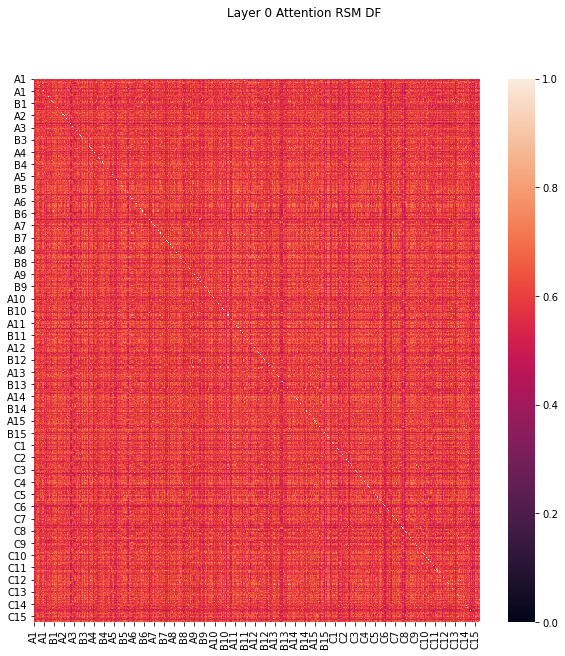

In [31]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[0], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

ax.set_xticks(ax.get_xticks()[::tick_interval])
ax.set_yticks(ax.get_yticks()[::tick_interval])

plt.suptitle("Layer 0 Attention RSM DF");

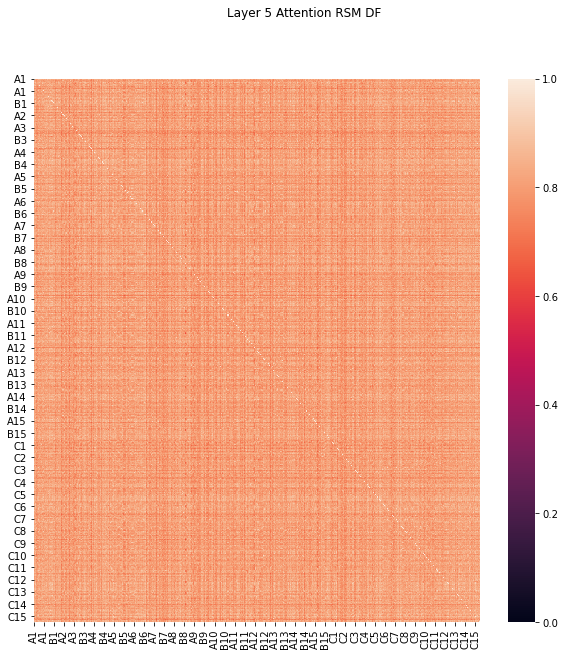

In [32]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[5], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

ax.set_xticks(ax.get_xticks()[::tick_interval])
ax.set_yticks(ax.get_yticks()[::tick_interval])

plt.suptitle("Layer 5 Attention RSM DF");

In [ ]:
for layer in range(0, len(attention_rsm_dfs)):
    
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(attention_rsm_dfs[layer], xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1)

    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_yticks(ax.get_yticks()[::tick_interval])

    plt.suptitle("Layer {} Attention RSM DF".format(layer+1));
    plt.show();

In [ ]:
fig, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(21, 7)) # switch to 2, 6
tick_interval = 100

for i, ax in enumerate(axs.flat):
    sns.heatmap(attention_rsm_dfs[i], ax=ax, xticklabels=token_stimulus_df[tick_labels], yticklabels=token_stimulus_df[tick_labels], vmin=0, vmax=1, cbar=False)
    ax.set_xticks(ax.get_xticks()[::tick_interval])
    ax.set_yticks(ax.get_yticks()[::tick_interval])
    
plt.show()

# for layer in range(0, len(attention_rsm_dfs)):
    
#     plt.figure(figsize=(10,10))
#     ax = 

#     ax.set_xticks(ax.get_xticks()[::tick_interval])
#     ax.set_yticks(ax.get_yticks()[::tick_interval])

#     plt.suptitle("Layer {} Attention RSM DF".format(layer+1));
#     plt.show();

In [112]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

from transformer_utils import TransformerRSM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
